## Planteamiento del problema

La primera pregunta que queremos responder es
**¿El ruido uniforme en las etiquetas, reduciendo (en número y proporción) el número de datos limpios, afecta al rendimiento?**

En este experimento, consideraremos el siguiente escenario:
- Tenemos $n$ imágenes con etiquetas limpias.
- Tomamos $m < n$ imágenes y cambiamos su etiqueta por una aleatoria entre las posibles.
- Por tanto, tenemos $m$ imágenes con etiquetas ruidosas y $n-m$ imágenes no ruidosas.

Las arquitecturas y *dataset* que utilizaremos en este experimento serán:
- Trabajaremos con el conjunto de datos ImageNet-100.
- Trabarejemos con varios modelos con distinto orden de complejidad: MLP con 2 capas ocultas, redes neuronales con 4 y 6 capas convolucionales, respectivamente y ResNet18.
- Utilizaremos ruido uniforme, en el que la etiqueta ruidosa se asigna aleatoriamente entre las clases posibles, todas con la misma probabilidad.

Realizaremos el entrenamiento con el conjunto de datos ruidoso y evaluaremos su rendimiento en un conjunto de test limpio (sin ruido).

## Instalación de fastai

In [ ]:
!pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from fastai.vision.all import *
import fastai
import numpy

print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
print("FastAI:", fastai.__version__)
print("NumPy:", numpy.__version__)

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch: 2.6.0+cu124
CUDA disponible: True
FastAI: 2.8.2
NumPy: 2.0.2


## Carga del *dataset* ImageNet-100

#### Descarga del *dataset* y organización en carpetas

Descargamos el *dataset* CIFAR-10:

In [ ]:
# We install the datasets library
_ = !pip install -U datasets

In [ ]:
from datasets import load_dataset

ds = load_dataset("clane9/imagenet-100")

Organizamos las imágenes en dos carpetas: una llamada *train*, con las imágenes de entrenamiento y otra llamada *validation*, con las imágenes de validación.

In [ ]:
# Definir la ruta base para almacenar las imágenes
base_path = Path('./imagenet-100')
train_path = base_path/'train'
valid_path = base_path/'validation'

# Crear las carpetas de train y validation si no existen
train_path.mkdir(parents=True, exist_ok=True)
valid_path.mkdir(parents=True, exist_ok=True)

# Listar las clases disponibles
classes = ds['train'].features['label'].names

# Crear las subcarpetas para cada clase en train y validation
for class_name in classes:
    (train_path/class_name).mkdir(parents=True, exist_ok=True)
    (valid_path/class_name).mkdir(parents=True, exist_ok=True)

In [ ]:
from io import BytesIO  # Aunque no lo usaremos directamente ahora

# Función para guardar imágenes en sus respectivas carpetas
def save_images(dataset, folder_path):
    for idx, example in enumerate(dataset):
        # Obtener el nombre de la clase (usando el índice de la etiqueta)
        class_name = classes[example['label']]

        # Crear la ruta de la subcarpeta de la clase
        class_folder = folder_path/class_name

        # Obtener la imagen desde el dataset (ya es un objeto PIL)
        img = example['image']  # Convertimos la imagen a PIL (si es necesario)

        # Crear un nombre para la imagen, usando el índice
        img_name = f"{class_name}_{idx}.jpg"  # Usa el índice para generar un nombre único

        # Guardar la imagen en la carpeta correspondiente
        img.save(class_folder/img_name)  # Guardamos la imagen como archivo en la carpeta adecuada

# Mover imágenes de train
save_images(ds['train'], train_path)

# Mover imágenes de validation (test)
save_images(ds['validation'], valid_path)

print("Estructura de carpetas y movimiento de imágenes completado.")

Estructura de carpetas y movimiento de imágenes completado.


#### Trabajando con el *dataset*

Comprobamos las *características* del dataset:

In [ ]:
train_classes = (train_path).ls()
test_classes = (valid_path).ls()

Comprobamos que efectivamente disponemos de unos $100000$ ejemplos de entrenamiento y $5000$ de *test* y que el número de clases es $100$.

In [ ]:
from cv2 import imread

n_training = np.sum([len(class_files.ls()) for class_files in train_classes])
n_test = np.sum([len(class_files.ls()) for class_files in test_classes])
num_classes = len(train_classes)

width = height = 224
num_channels = 3

print(f"Número de imágenes de entrenamiento: {n_training}")
print(f"Número de imágenes de test: {n_test}")
print(f"Número de clases: {num_classes}")

Número de imágenes de entrenamiento: 126689
Número de imágenes de test: 5000
Número de clases: 100


Seleccionamos la proporción de ruido deseado y fijamos la semilla aleatoria con el fin de garantizar la reproducibilidad en la mayor medida posible.

In [ ]:
prop_ruido = 0
random.seed(42)

Seleccionamos todas las imágenes del entrenamiento:

In [ ]:
selected_images = get_image_files(train_path)

In [ ]:
len(selected_images)

126689

Creamos una función que selecciona las imágenes del conjunto de entrenamiento, y a cierto porcentaje les asigna una etiqueta de forma aleatoria (uniforme):

In [ ]:
possible_labels = ['African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus', 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier', 'American coot, marsh hen, mud hen, water hen, Fulica americana', 'American lobster, Northern lobster, Maine lobster, Homarus americanus', 'Chesapeake Bay retriever', 'Chihuahua', 'Doberman, Doberman pinscher', 'Dutch oven', 'English foxhound', 'Gila monster, Heloderma suspectum', 'Great Dane', 'Mexican hairless', 'Rottweiler', 'Saluki, gazelle hound', 'Shih-Tzu', 'Walker hound, Walker foxhound', 'ambulance', 'bannister, banister, balustrade, balusters, handrail', 'bassinet', 'boathouse', 'bonnet, poke bonnet', 'borzoi, Russian wolfhound', 'bottlecap', 'boxer', 'car wheel', 'carbonara', 'cauliflower', 'chime, bell, gong', 'chocolate sauce, chocolate syrup', 'cinema, movie theater, movie theatre, movie house, picture palace', 'cocktail shaker', 'computer keyboard, keypad', 'coyote, prairie wolf, brush wolf, Canis latrans', 'dung beetle', 'fiddler crab', 'football helmet', 'garden spider, Aranea diademata', 'garter snake, grass snake', 'gasmask, respirator, gas helmet', 'gibbon, Hylobates lar', 'goose', 'green mamba', 'gyromitra', 'hard disc, hard disk, fixed disk', 'hare', 'harmonica, mouth organ, harp, mouth harp', 'head cabbage', 'hognose snake, puff adder, sand viper', 'honeycomb', 'iron, smoothing iron', 'jean, blue jean, denim', 'komondor', 'kuvasz', 'lampshade, lamp shade', 'langur', 'laptop, laptop computer', 'leafhopper', 'little blue heron, Egretta caerulea', 'lorikeet', 'meerkat, mierkat', 'milk can', 'mixing bowl', 'modem', 'moped', 'mortarboard', 'mousetrap', 'obelisk', 'papillon', 'park bench', 'pedestal, plinth, footstall', 'pickup, pickup truck', 'pineapple, ananas', 'pirate, pirate ship', 'purse', 'red fox, Vulpes vulpes', 'reel', 'robin, American robin, Turdus migratorius', 'rock crab, Cancer irroratus', 'rocking chair, rocker', 'rotisserie', 'safety pin', 'sarong', 'ski mask', 'slide rule, slipstick', 'standard poodle', 'stinkhorn, carrion fungus', 'stretcher', 'tabby, tabby cat', 'theater curtain, theatre curtain', 'throne', 'tile roof', 'toy terrier', 'tripod', 'tub, vat', 'vacuum, vacuum cleaner', 'vizsla, Hungarian pointer', 'walking stick, walkingstick, stick insect', 'wild boar, boar, Sus scrofa', 'window screen', 'wing']

In [ ]:
def get_labels(images):
  i = 0
  labels = []

  for i in range(len(images)):
    labels.append(parent_label(images[i]))

  cantidad = int(prop_ruido*len(images))
  inds_cambio = random.sample(range(len(images)), cantidad)

  for i in inds_cambio:
    labels[i] = random.choice(possible_labels)

  return labels

In [ ]:
labels = get_labels(selected_images)

Mostramos el número de etiquetas incorrectas en el *dataset*:

In [ ]:
num_incorrectas = 0
for i in range(len(labels)):
  if labels[i] != parent_label(selected_images[i]):
    num_incorrectas += 1

print(f"Número real de etiquetas incorrectas:     {num_incorrectas}")

prob_etiqueta_incorrecta = (num_classes-1)/num_classes
print(f"Número esperado de etiquetas incorrectas: {int(prop_ruido*n_training*prob_etiqueta_incorrecta)}")

Número real de etiquetas incorrectas:     0
Número esperado de etiquetas incorrectas: 0


Combinamos todo en un *datablock* (que es la forma que tiene fastai de gestionar los datos de entrada):

In [ ]:
batch_size = 128
valid_part = 0.2

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda _: range(0,len(selected_images)),
    get_x=lambda x: selected_images[x],
    get_y=lambda x: labels[x],
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
    batch_tfms=Normalize.from_stats(*imagenet_stats)
)

dls = dblock.dataloaders(train_path, bs=128)

Mostramos algunos ejemplos de nuestros datos de entrada:

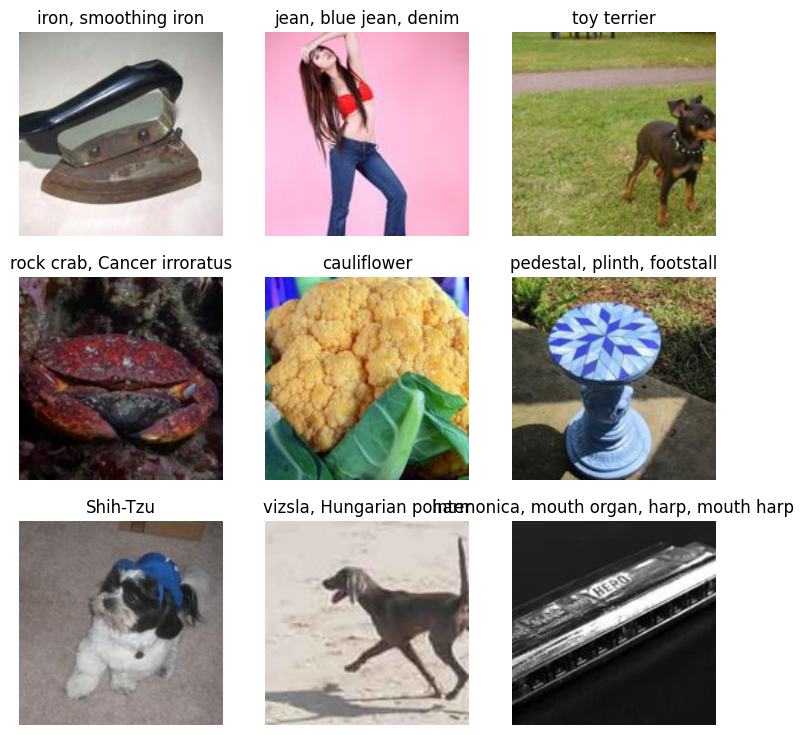

In [ ]:
dls.show_batch(max_n=9)

## Arquitecturas de redes neuronales

Creamos y entrenamos los distintos modelos durante un cierto número de épocas.

In [ ]:
num_epochs = 3
early_stopping_patience = 3

### MLP-2

Seleccionamos el *learning rate*:

In [ ]:
learning_rate = 0.1

En primer lugar, consideramos un MLP con $2$ capas ocultas.

#### Creación del modelo

In [ ]:
from torch.nn import Linear, ReLU, Flatten, BatchNorm1d
from torch.optim import Adadelta
from torchsummary import summary

# Crear el MLP con 2 capas ocultas
opt_func = partial(OptimWrapper, opt=Adadelta, lr=learning_rate)

mlp2 = sequential(
    Flatten(),                              # Aplana la imagen de 28x28 a un vector de 784
    Linear(width*height*num_channels, 512), # Capa densa con tantas entradas como píxeles tenga la imagen y 512 salidas
    ReLU(),                                 # Función de activación ReLU
    BatchNorm1d(512),                       # Capa de Batch Normalization
    Linear(512, 512),                       # Capa densa con 512 entradas y 512 salidas
    ReLU(),                                 # Función de activación ReLU
    BatchNorm1d(512),                       # Capa de Batch Normalization
    Linear(512, num_classes)                # Capa de salida con num_classes salidas
)

# Crear el aprendiz (learner)
learn = Learner(
    dls,
    mlp2,
    metrics=[
        accuracy,
        F1Score(average='weighted')
    ],
    opt_func=opt_func,
    loss_func=CrossEntropyLossFlat(),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=early_stopping_patience)]
)

In [ ]:
learn.summary()

Sequential (Input shape: 128 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 150528        
Flatten                                                        
____________________________________________________________________________
                     128 x 512           
Linear                                    77070848   True      
ReLU                                                           
BatchNorm1d                               1024       True      
Linear                                    262656     True      
ReLU                                                           
BatchNorm1d                               1024       True      
____________________________________________________________________________
                     128 x 100           
Linear                                    51300      True      
____________________________________________________________________________

Total params: 77,386

#### Entrenamiento del modelo

In [ ]:
learn.fit(num_epochs,lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.898138,3.857002,0.132060,0.107467,04:51
1,3.728691,3.715256,0.156925,0.133974,04:17
2,3.616397,3.636575,0.163778,0.156085,04:14


#### Rendimiento en el conjunto de *test*

Medimos ahora el rendimiento utilizando el conjunto de test:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def accuracy_f1_test(test_path, learner):
  files_test = get_image_files(test_path)
  dls_test = learner.dls.test_dl(files_test, with_labels = False)
  preds = learner.get_preds(dl = dls_test, with_decoded = True)

  preds_labels = [learner.dls.vocab[i] for i in preds[2]]
  targs = [parent_label(f) for f in files_test]

  test_accuracy = accuracy_score(preds_labels, targs)
  test_f1 = f1_score(preds_labels, targs, average='weighted')

  print(f"Accuracy en test: {test_accuracy:.2f}")
  print(f"F1 en test: {test_f1:.2f}")

In [ ]:
accuracy_f1_test(valid_path, learn)

Accuracy en test: 0.16
F1 en test: 0.17


### Conv4

Seleccionamos el *learning rate*:

In [ ]:
learning_rate = 0.1

Consideramos ahora una red neuronal con $4$ capas convolucionales:

#### Creación del modelo

In [ ]:
from torch.nn import Linear, LazyLinear, ReLU, Flatten, Conv2d, MaxPool2d, BatchNorm2d
from torch.optim import Adadelta
from torchsummary import summary

# Crear el modelo de 4 capas convolucionales
opt_func = partial(OptimWrapper, opt=Adadelta, lr=learning_rate)

conv4 = sequential(

    # 1ª Capa convolucional:
    # - Tantos canales de entrada como tenga la imagen de entrada
    # - 8 canales de salida
    # - Filtro 3x3
    Conv2d(num_channels, 8, 3),
    ReLU(),                          # Capa ReLU
    MaxPool2d(2),                    # Capa MaxPooling (Filtro 2x2)
    BatchNorm2d(8),                  # Capa de Batch Normalization

    # 2ª Capa convolucional:
    # - 8 canales de entrada y 16 de salida
    # - Filtro 3x3
    Conv2d(8, 16, 3),
    ReLU(),                          # Capa ReLU
    MaxPool2d(2),                    # Capa MaxPooling (Filtro 2x2)
    BatchNorm2d(16),                 # Capa de Batch Normalization

    # 3ª Capa convolucional:
    # - 16 canales de entrada y 16 de salida
    # - Filtro 3x3
    Conv2d(16, 16, 3),
    ReLU(),                          # Capa ReLU
    BatchNorm2d(16),                 # Capa de Batch Normalization

    # 4ª Capa convolucional:
    # - 16 canales de entrada y 4 de salida
    # - Filtro 1x1
    Conv2d(16,4,(1,1)),
    ReLU(),                          # Capa ReLU
    BatchNorm2d(4),                  # Capa de Batch Normalization
    Flatten(),                       # Aplanado de la salida

    # Capa densa con 64 salidas (el nº de entradas se ajusta automáticamente)
    LazyLinear(64),
    ReLU(),                          # Capa ReLU
    Linear(64, num_classes)          # Capa densa con num_classes salidas
)


# Crear el aprendiz (learner)
learn = Learner(
    dls,
    conv4,
    metrics=[
        accuracy,
        F1Score(average='weighted')
    ],
    opt_func=opt_func,
    loss_func=CrossEntropyLossFlat(),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=early_stopping_patience)]
)

In [ ]:
learn.summary()

Sequential (Input shape: 128 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 8 x 222 x 222 
Conv2d                                    224        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 8 x 111 x 111 
MaxPool2d                                                      
BatchNorm2d                               16         True      
____________________________________________________________________________
                     128 x 16 x 109 x 10 
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 54 x 54  
MaxPool2d                                                      
BatchNorm2d                               3

#### Entrenamiento del modelo

In [ ]:
learn.fit(num_epochs,lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.848029,3.781453,0.131507,0.107037,04:05
1,3.619752,3.617890,0.154359,0.131482,04:05
2,3.490166,3.510828,0.172436,0.163407,04:07


#### Rendimiento en el conjunto de *test*

In [ ]:
accuracy_f1_test(valid_path, learn)

Accuracy en test: 0.18
F1 en test: 0.18


### Conv6

Seleccionamos el *learning rate*:

In [ ]:
learning_rate = 0.1

Consideramos ahora una red neuronal con $6$ capas convolucionales:

#### Creación del modelo

In [ ]:
from torch.nn import Linear, LazyLinear, ReLU, Flatten, Conv2d, MaxPool2d, BatchNorm2d, Dropout, BatchNorm1d
from torch.optim import Adadelta
from torchsummary import summary

# Crear el MLP con 2 capas ocultas
opt_func = partial(OptimWrapper, opt=Adadelta, lr=learning_rate)

conv6 = sequential(

    # 1ª Capa convolucional:
    # - Tantos canales de entrada como tenga la imagen de entrada
    # - 32 canales de salida
    # - Filtro 3x3
    Conv2d(num_channels, 32, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(32),                                   # Capa BatchNorm

    # 2ª Capa convolucional:
    # - 32 canales de entrada y 64 de salida
    # - Filtro 3x3
    Conv2d(32, 64, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(64),                                   # Capa BatchNorm
    MaxPool2d(2),                                      # Capa MaxPooling
    Dropout(0.2),                                      # Capa Dropout (apago el 20% de las neuronas)

    # 3ª Capa convolucional:
    # - 64 canales de entrada y 64 de salida
    # - Filtro 3x3
    Conv2d(64, 64, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(64),                                   # Capa BatchNorm

    # 4ª Capa convolucional:
    # - 64 canales de entrada y 64 de salida
    # - Filtro 3x3
    Conv2d(64, 64, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(64),                                   # Capa BatchNorm
    MaxPool2d(2),                                      # Capa MaxPooling
    Dropout(0.3),                                      # Capa Dropout

    # 5ª Capa convolucional:
    # - 64 canales de entrada y 128 de salida
    # - Filtro 3x3
    Conv2d(64, 128, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(128),                                  # Capa BatchNorm

    # 6ª Capa convolucional:
    # - 128 canales de entrada y 128 de salida
    # - Filtro 3x3
    Conv2d(128, 128, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(128),                                  # Capa BatchNorm
    MaxPool2d(2),                                      # Capa MaxPooling
    Dropout(0.4),                                      # Capa Dropout
    Flatten(),                                         # Aplanado

    # Capa densa con 128 salidas (el nº de entradas se ajusta automáticamente)
    LazyLinear(128),
    ReLU(),                                            # Capa ReLU
    BatchNorm1d(128),                                  # Capa BatchNorm
    Dropout(0.5),                                      # Capa Dropout
    Linear(128, num_classes)                           # Capa densa con num_classes salidas
)


# Crear el aprendiz (learner)
learn = Learner(
    dls,
    conv6,
    metrics=[
        accuracy,
        F1Score(average='weighted')
    ],
    opt_func=opt_func,
    loss_func=CrossEntropyLossFlat(),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)]
)

In [ ]:
learn.summary()

Sequential (Input shape: 128 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 32 x 224 x 22 
Conv2d                                    896        True      
ReLU                                                           
BatchNorm2d                               64         True      
____________________________________________________________________________
                     128 x 64 x 224 x 22 
Conv2d                                    18496      True      
ReLU                                                           
BatchNorm2d                               128        True      
____________________________________________________________________________
                     128 x 64 x 112 x 11 
MaxPool2d                                                      
Dropout                                                        
Conv2d                                    36928      True      
ReLU                              

#### Entrenamiento del modelo

In [ ]:
learn.fit(num_epochs,lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.666657,3.601820,0.207325,0.169319,11:58
1,3.190616,3.158793,0.277105,0.250619,11:58
2,2.884161,2.740698,0.323292,0.320524,11:58


#### Rendimiento en el conjunto de *test*

In [ ]:
accuracy_f1_test(valid_path, learn)

Accuracy en test: 0.31
F1 en test: 0.33


### ResNet18

Seleccionamos el *learning rate*:

In [ ]:
learning_rate = 0.1

Consideramos ahora el modelo ResNet18:

#### Creación del modelo

In [ ]:
from torch.optim import Adadelta

# Crear el MLP con 2 capas ocultas
opt_func = partial(OptimWrapper, opt=Adadelta, lr=learning_rate)

model = models.resnet18

# pretrained = True, pesos preentrenados en ImageNet
learn = vision_learner(dls,
                       model,
                       pretrained = True,
                       n_in=num_channels,
                       metrics=[accuracy, F1Score(average='weighted')],
                       opt_func=opt_func,
                       loss_func=CrossEntropyLossFlat(),
                       cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=early_stopping_patience)])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


#### Entrenamiento del modelo

In [ ]:
# Entrenamos la cabecera del modelo
learn.fit(num_epochs, lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.729206,0.459489,0.869795,0.869270,05:02
1,0.611253,0.401126,0.884872,0.884583,05:01
2,0.537910,0.381188,0.890042,0.889934,05:00


#### Rendimiento en el conjunto de *test*

In [ ]:
accuracy_f1_test(valid_path, learn)

Accuracy en test: 0.85
F1 en test: 0.85
